In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'low_resolution', 'original', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'random_occlusion', 'dirty_lens', 'blur'}
Validation folders considered: {'low_resolution', 'original', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'random_occlusion', 'dirty_lens', 'blur'}
Test folders considered: {'low_resolution', 'original', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'random_occlusion', 'dirty_lens', 'blur'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'low_resolution', 'original', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'dirty_lens', 'blur'}
Validation folders considered: {'low_resolution', 'original', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'dirty_lens', 'blur'}
Test folders considered: {'low_resolution', 'original', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'dirty_lens', 'blur'}


In [7]:
classes = train_ds.classes
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Number of classes: 5
Train samples: 1704
Val samples: 448
Test samples: 560


In [8]:
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.models as models

In [9]:
# -----------------------------
# 2. Pretrained DenseNet121 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained DenseNet121
print("🔄 Loading pretrained DenseNet121 from ImageNet...")
model = models.densenet121(pretrained=True)

# Replace final classification layer
num_features = model.classifier.in_features  # Get input features (1024)
model.classifier = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"✅ Model loaded with {len(classes)} output classes")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Alternative model info (without torchsummary)
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ DenseNet121 features: 1024")
print(f"│ Output classes: {len(classes)}")

Using device: cuda
🔄 Loading pretrained DenseNet121 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 166MB/s] 


✅ Model loaded with 5 output classes
📊 Total parameters: 6,958,981
📊 Trainable parameters: 6,958,981
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ DenseNet121 features: 1024
│ Output classes: 5



📋 Training Configuration:
│ Model: DenseNet121 (pretrained)
│ Optimizer: Adam (lr=0.0001)
│ Loss Function: CrossEntropyLoss
│ Batch Size: 32
│ Device: cuda

🚀 Starting DenseNet121 Fine-tuning for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:36<00:00,  1.46it/s, Loss=0.7357, Acc=0.7887]


✅ Training completed in 36.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.56it/s, Loss=0.8659, Acc=0.6496]


✅ Validation completed in 5.46s
🌟 New best model found! Validation Loss: 0.8659

📊 Epoch 1 Summary:
│ Train Loss: 0.7357 | Train Acc: 0.7887
│ Val Loss:   0.8659 | Val Acc:   0.6496
│ Train Time: 36.97s | Val Time: 5.46s
│ Total Epoch Time: 42.44s
│ Best Val Loss: 0.8659 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.90it/s, Loss=0.1050, Acc=0.9924]


✅ Training completed in 28.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.57it/s, Loss=0.8281, Acc=0.6518]


✅ Validation completed in 3.93s
🌟 New best model found! Validation Loss: 0.8281

📊 Epoch 2 Summary:
│ Train Loss: 0.1050 | Train Acc: 0.9924
│ Val Loss:   0.8281 | Val Acc:   0.6518
│ Train Time: 28.40s | Val Time: 3.93s
│ Total Epoch Time: 32.34s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0337, Acc=0.9982]


✅ Training completed in 29.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.36it/s, Loss=0.9385, Acc=0.6786]


✅ Validation completed in 4.17s

📊 Epoch 3 Summary:
│ Train Loss: 0.0337 | Train Acc: 0.9982
│ Val Loss:   0.9385 | Val Acc:   0.6786
│ Train Time: 29.34s | Val Time: 4.17s
│ Total Epoch Time: 33.51s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:30<00:00,  1.77it/s, Loss=0.0235, Acc=0.9982]


✅ Training completed in 30.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.13it/s, Loss=0.8966, Acc=0.6853]


✅ Validation completed in 4.47s

📊 Epoch 4 Summary:
│ Train Loss: 0.0235 | Train Acc: 0.9982
│ Val Loss:   0.8966 | Val Acc:   0.6853
│ Train Time: 30.54s | Val Time: 4.47s
│ Total Epoch Time: 35.02s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.88it/s, Loss=0.0112, Acc=1.0000]


✅ Training completed in 28.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.59it/s, Loss=0.9585, Acc=0.6763]


✅ Validation completed in 3.90s

📊 Epoch 5 Summary:
│ Train Loss: 0.0112 | Train Acc: 1.0000
│ Val Loss:   0.9585 | Val Acc:   0.6763
│ Train Time: 28.78s | Val Time: 3.90s
│ Total Epoch Time: 32.69s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.87it/s, Loss=0.0065, Acc=1.0000]


✅ Training completed in 28.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.49it/s, Loss=0.9311, Acc=0.6629]


✅ Validation completed in 4.01s

📊 Epoch 6 Summary:
│ Train Loss: 0.0065 | Train Acc: 1.0000
│ Val Loss:   0.9311 | Val Acc:   0.6629
│ Train Time: 28.85s | Val Time: 4.01s
│ Total Epoch Time: 32.87s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0053, Acc=1.0000]


✅ Training completed in 29.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.39it/s, Loss=0.9659, Acc=0.6585]


✅ Validation completed in 4.13s

📊 Epoch 7 Summary:
│ Train Loss: 0.0053 | Train Acc: 1.0000
│ Val Loss:   0.9659 | Val Acc:   0.6585
│ Train Time: 29.20s | Val Time: 4.13s
│ Total Epoch Time: 33.34s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.83it/s, Loss=0.0040, Acc=1.0000]


✅ Training completed in 29.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.50it/s, Loss=0.9395, Acc=0.6853]


✅ Validation completed in 4.00s

📊 Epoch 8 Summary:
│ Train Loss: 0.0040 | Train Acc: 1.0000
│ Val Loss:   0.9395 | Val Acc:   0.6853
│ Train Time: 29.54s | Val Time: 4.00s
│ Total Epoch Time: 33.55s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.86it/s, Loss=0.0037, Acc=1.0000]


✅ Training completed in 29.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.44it/s, Loss=1.0021, Acc=0.6763]


✅ Validation completed in 4.07s

📊 Epoch 9 Summary:
│ Train Loss: 0.0037 | Train Acc: 1.0000
│ Val Loss:   1.0021 | Val Acc:   0.6763
│ Train Time: 29.09s | Val Time: 4.07s
│ Total Epoch Time: 33.17s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.86it/s, Loss=0.0043, Acc=1.0000]


✅ Training completed in 28.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.54it/s, Loss=0.9346, Acc=0.6696]


✅ Validation completed in 3.96s

📊 Epoch 10 Summary:
│ Train Loss: 0.0043 | Train Acc: 1.0000
│ Val Loss:   0.9346 | Val Acc:   0.6696
│ Train Time: 28.98s | Val Time: 3.96s
│ Total Epoch Time: 32.94s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0043, Acc=0.9994]


✅ Training completed in 29.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.48it/s, Loss=0.9947, Acc=0.6875]


✅ Validation completed in 4.03s

📊 Epoch 11 Summary:
│ Train Loss: 0.0043 | Train Acc: 0.9994
│ Val Loss:   0.9947 | Val Acc:   0.6875
│ Train Time: 29.18s | Val Time: 4.03s
│ Total Epoch Time: 33.21s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0109, Acc=0.9977]


✅ Training completed in 29.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.56it/s, Loss=1.5254, Acc=0.6362]


✅ Validation completed in 3.93s

📊 Epoch 12 Summary:
│ Train Loss: 0.0109 | Train Acc: 0.9977
│ Val Loss:   1.5254 | Val Acc:   0.6362
│ Train Time: 29.27s | Val Time: 3.93s
│ Total Epoch Time: 33.21s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0288, Acc=0.9935]


✅ Training completed in 29.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.36it/s, Loss=1.1811, Acc=0.6562]


✅ Validation completed in 4.17s

📊 Epoch 13 Summary:
│ Train Loss: 0.0288 | Train Acc: 0.9935
│ Val Loss:   1.1811 | Val Acc:   0.6562
│ Train Time: 29.37s | Val Time: 4.17s
│ Total Epoch Time: 33.55s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0064, Acc=1.0000]


✅ Training completed in 29.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.56it/s, Loss=1.1279, Acc=0.6607]


✅ Validation completed in 3.94s

📊 Epoch 14 Summary:
│ Train Loss: 0.0064 | Train Acc: 1.0000
│ Val Loss:   1.1279 | Val Acc:   0.6607
│ Train Time: 29.33s | Val Time: 3.94s
│ Total Epoch Time: 33.28s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.83it/s, Loss=0.0057, Acc=0.9982]


✅ Training completed in 29.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.41it/s, Loss=1.0392, Acc=0.6741]


✅ Validation completed in 4.11s

📊 Epoch 15 Summary:
│ Train Loss: 0.0057 | Train Acc: 0.9982
│ Val Loss:   1.0392 | Val Acc:   0.6741
│ Train Time: 29.55s | Val Time: 4.11s
│ Total Epoch Time: 33.66s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0033, Acc=1.0000]


✅ Training completed in 29.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.39it/s, Loss=1.1334, Acc=0.6607]


✅ Validation completed in 4.14s

📊 Epoch 16 Summary:
│ Train Loss: 0.0033 | Train Acc: 1.0000
│ Val Loss:   1.1334 | Val Acc:   0.6607
│ Train Time: 29.17s | Val Time: 4.14s
│ Total Epoch Time: 33.32s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0021, Acc=1.0000]


✅ Training completed in 29.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.41it/s, Loss=1.1293, Acc=0.6741]


✅ Validation completed in 4.11s

📊 Epoch 17 Summary:
│ Train Loss: 0.0021 | Train Acc: 1.0000
│ Val Loss:   1.1293 | Val Acc:   0.6741
│ Train Time: 29.33s | Val Time: 4.11s
│ Total Epoch Time: 33.44s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0017, Acc=1.0000]


✅ Training completed in 29.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.42it/s, Loss=1.1473, Acc=0.6719]


✅ Validation completed in 4.09s

📊 Epoch 18 Summary:
│ Train Loss: 0.0017 | Train Acc: 1.0000
│ Val Loss:   1.1473 | Val Acc:   0.6719
│ Train Time: 29.26s | Val Time: 4.09s
│ Total Epoch Time: 33.36s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0012, Acc=1.0000]


✅ Training completed in 29.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.44it/s, Loss=1.0977, Acc=0.6853]


✅ Validation completed in 4.07s

📊 Epoch 19 Summary:
│ Train Loss: 0.0012 | Train Acc: 1.0000
│ Val Loss:   1.0977 | Val Acc:   0.6853
│ Train Time: 29.37s | Val Time: 4.07s
│ Total Epoch Time: 33.45s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0012, Acc=1.0000]


✅ Training completed in 29.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.46it/s, Loss=1.1006, Acc=0.6786]


✅ Validation completed in 4.05s

📊 Epoch 20 Summary:
│ Train Loss: 0.0012 | Train Acc: 1.0000
│ Val Loss:   1.1006 | Val Acc:   0.6786
│ Train Time: 29.19s | Val Time: 4.05s
│ Total Epoch Time: 33.25s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0010, Acc=1.0000]


✅ Training completed in 29.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.45it/s, Loss=1.0818, Acc=0.6786]


✅ Validation completed in 4.07s

📊 Epoch 21 Summary:
│ Train Loss: 0.0010 | Train Acc: 1.0000
│ Val Loss:   1.0818 | Val Acc:   0.6786
│ Train Time: 29.37s | Val Time: 4.07s
│ Total Epoch Time: 33.44s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0010, Acc=1.0000]


✅ Training completed in 29.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.40it/s, Loss=1.1664, Acc=0.6763]


✅ Validation completed in 4.12s

📊 Epoch 22 Summary:
│ Train Loss: 0.0010 | Train Acc: 1.0000
│ Val Loss:   1.1664 | Val Acc:   0.6763
│ Train Time: 29.22s | Val Time: 4.12s
│ Total Epoch Time: 33.34s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0008, Acc=1.0000]


✅ Training completed in 29.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.47it/s, Loss=1.2136, Acc=0.6897]


✅ Validation completed in 4.04s

📊 Epoch 23 Summary:
│ Train Loss: 0.0008 | Train Acc: 1.0000
│ Val Loss:   1.2136 | Val Acc:   0.6897
│ Train Time: 29.29s | Val Time: 4.04s
│ Total Epoch Time: 33.33s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0009, Acc=1.0000]


✅ Training completed in 29.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.47it/s, Loss=1.1834, Acc=0.6920]


✅ Validation completed in 4.04s

📊 Epoch 24 Summary:
│ Train Loss: 0.0009 | Train Acc: 1.0000
│ Val Loss:   1.1834 | Val Acc:   0.6920
│ Train Time: 29.26s | Val Time: 4.04s
│ Total Epoch Time: 33.30s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0007, Acc=1.0000]


✅ Training completed in 29.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.46it/s, Loss=1.1854, Acc=0.6964]


✅ Validation completed in 4.04s

📊 Epoch 25 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   1.1854 | Val Acc:   0.6964
│ Train Time: 29.13s | Val Time: 4.04s
│ Total Epoch Time: 33.18s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0011, Acc=1.0000]


✅ Training completed in 29.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.55it/s, Loss=1.1126, Acc=0.6897]


✅ Validation completed in 3.95s

📊 Epoch 26 Summary:
│ Train Loss: 0.0011 | Train Acc: 1.0000
│ Val Loss:   1.1126 | Val Acc:   0.6897
│ Train Time: 29.25s | Val Time: 3.95s
│ Total Epoch Time: 33.21s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.86it/s, Loss=0.0044, Acc=0.9988]


✅ Training completed in 29.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.47it/s, Loss=1.1410, Acc=0.7098]


✅ Validation completed in 4.04s

📊 Epoch 27 Summary:
│ Train Loss: 0.0044 | Train Acc: 0.9988
│ Val Loss:   1.1410 | Val Acc:   0.7098
│ Train Time: 29.06s | Val Time: 4.04s
│ Total Epoch Time: 33.11s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.86it/s, Loss=0.0051, Acc=0.9982]


✅ Training completed in 28.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.56it/s, Loss=1.1904, Acc=0.6897]


✅ Validation completed in 3.94s

📊 Epoch 28 Summary:
│ Train Loss: 0.0051 | Train Acc: 0.9982
│ Val Loss:   1.1904 | Val Acc:   0.6897
│ Train Time: 28.98s | Val Time: 3.94s
│ Total Epoch Time: 32.92s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0337, Acc=0.9912]


✅ Training completed in 29.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.55it/s, Loss=1.2904, Acc=0.7031]


✅ Validation completed in 3.95s

📊 Epoch 29 Summary:
│ Train Loss: 0.0337 | Train Acc: 0.9912
│ Val Loss:   1.2904 | Val Acc:   0.7031
│ Train Time: 29.14s | Val Time: 3.95s
│ Total Epoch Time: 33.10s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.86it/s, Loss=0.0285, Acc=0.9906]


✅ Training completed in 29.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.54it/s, Loss=1.5347, Acc=0.6317]


✅ Validation completed in 3.96s

📊 Epoch 30 Summary:
│ Train Loss: 0.0285 | Train Acc: 0.9906
│ Val Loss:   1.5347 | Val Acc:   0.6317
│ Train Time: 29.07s | Val Time: 3.96s
│ Total Epoch Time: 33.03s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.83it/s, Loss=0.0156, Acc=0.9977]


✅ Training completed in 29.49s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.30it/s, Loss=1.2408, Acc=0.6853]


✅ Validation completed in 4.24s

📊 Epoch 31 Summary:
│ Train Loss: 0.0156 | Train Acc: 0.9977
│ Val Loss:   1.2408 | Val Acc:   0.6853
│ Train Time: 29.49s | Val Time: 4.24s
│ Total Epoch Time: 33.73s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.83it/s, Loss=0.0159, Acc=0.9988]


✅ Training completed in 29.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.46it/s, Loss=1.1966, Acc=0.7009]


✅ Validation completed in 4.05s

📊 Epoch 32 Summary:
│ Train Loss: 0.0159 | Train Acc: 0.9988
│ Val Loss:   1.1966 | Val Acc:   0.7009
│ Train Time: 29.47s | Val Time: 4.05s
│ Total Epoch Time: 33.53s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0294, Acc=0.9883]


✅ Training completed in 29.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.48it/s, Loss=1.3403, Acc=0.6317]


✅ Validation completed in 4.03s

📊 Epoch 33 Summary:
│ Train Loss: 0.0294 | Train Acc: 0.9883
│ Val Loss:   1.3403 | Val Acc:   0.6317
│ Train Time: 29.36s | Val Time: 4.03s
│ Total Epoch Time: 33.39s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0090, Acc=0.9977]


✅ Training completed in 29.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.53it/s, Loss=1.2164, Acc=0.6830]


✅ Validation completed in 3.97s

📊 Epoch 34 Summary:
│ Train Loss: 0.0090 | Train Acc: 0.9977
│ Val Loss:   1.2164 | Val Acc:   0.6830
│ Train Time: 29.33s | Val Time: 3.97s
│ Total Epoch Time: 33.31s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.84it/s, Loss=0.0034, Acc=1.0000]


✅ Training completed in 29.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.46it/s, Loss=1.2594, Acc=0.7054]


✅ Validation completed in 4.05s

📊 Epoch 35 Summary:
│ Train Loss: 0.0034 | Train Acc: 1.0000
│ Val Loss:   1.2594 | Val Acc:   0.7054
│ Train Time: 29.38s | Val Time: 4.05s
│ Total Epoch Time: 33.44s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0019, Acc=1.0000]


✅ Training completed in 29.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.51it/s, Loss=1.2174, Acc=0.7143]


✅ Validation completed in 3.99s

📊 Epoch 36 Summary:
│ Train Loss: 0.0019 | Train Acc: 1.0000
│ Val Loss:   1.2174 | Val Acc:   0.7143
│ Train Time: 29.16s | Val Time: 3.99s
│ Total Epoch Time: 33.16s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0010, Acc=1.0000]


✅ Training completed in 29.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.54it/s, Loss=1.1636, Acc=0.6987]


✅ Validation completed in 3.96s

📊 Epoch 37 Summary:
│ Train Loss: 0.0010 | Train Acc: 1.0000
│ Val Loss:   1.1636 | Val Acc:   0.6987
│ Train Time: 29.13s | Val Time: 3.96s
│ Total Epoch Time: 33.10s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.86it/s, Loss=0.0063, Acc=0.9994]


✅ Training completed in 28.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.49it/s, Loss=1.1963, Acc=0.6250]


✅ Validation completed in 4.01s

📊 Epoch 38 Summary:
│ Train Loss: 0.0063 | Train Acc: 0.9994
│ Val Loss:   1.1963 | Val Acc:   0.6250
│ Train Time: 28.98s | Val Time: 4.01s
│ Total Epoch Time: 33.00s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.86it/s, Loss=0.0263, Acc=0.9941]


✅ Training completed in 29.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.51it/s, Loss=1.7906, Acc=0.6429]


✅ Validation completed in 3.99s

📊 Epoch 39 Summary:
│ Train Loss: 0.0263 | Train Acc: 0.9941
│ Val Loss:   1.7906 | Val Acc:   0.6429
│ Train Time: 29.05s | Val Time: 3.99s
│ Total Epoch Time: 33.04s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0090, Acc=0.9982]


✅ Training completed in 29.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.45it/s, Loss=1.3072, Acc=0.7232]


✅ Validation completed in 4.06s

📊 Epoch 40 Summary:
│ Train Loss: 0.0090 | Train Acc: 0.9982
│ Val Loss:   1.3072 | Val Acc:   0.7232
│ Train Time: 29.17s | Val Time: 4.06s
│ Total Epoch Time: 33.24s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0040, Acc=0.9994]


✅ Training completed in 29.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.54it/s, Loss=1.3381, Acc=0.7433]


✅ Validation completed in 3.96s

📊 Epoch 41 Summary:
│ Train Loss: 0.0040 | Train Acc: 0.9994
│ Val Loss:   1.3381 | Val Acc:   0.7433
│ Train Time: 29.22s | Val Time: 3.96s
│ Total Epoch Time: 33.18s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0008, Acc=1.0000]


✅ Training completed in 29.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.51it/s, Loss=1.2806, Acc=0.7522]


✅ Validation completed in 4.00s

📊 Epoch 42 Summary:
│ Train Loss: 0.0008 | Train Acc: 1.0000
│ Val Loss:   1.2806 | Val Acc:   0.7522
│ Train Time: 29.13s | Val Time: 4.00s
│ Total Epoch Time: 33.13s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.87it/s, Loss=0.0015, Acc=1.0000]


✅ Training completed in 28.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.51it/s, Loss=1.2805, Acc=0.7478]


✅ Validation completed in 4.00s

📊 Epoch 43 Summary:
│ Train Loss: 0.0015 | Train Acc: 1.0000
│ Val Loss:   1.2805 | Val Acc:   0.7478
│ Train Time: 28.95s | Val Time: 4.00s
│ Total Epoch Time: 32.95s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.87it/s, Loss=0.0031, Acc=0.9988]


✅ Training completed in 28.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.57it/s, Loss=1.4330, Acc=0.7232]


✅ Validation completed in 3.92s

📊 Epoch 44 Summary:
│ Train Loss: 0.0031 | Train Acc: 0.9988
│ Val Loss:   1.4330 | Val Acc:   0.7232
│ Train Time: 28.87s | Val Time: 3.92s
│ Total Epoch Time: 32.80s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.87it/s, Loss=0.0121, Acc=0.9965]


✅ Training completed in 28.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.47it/s, Loss=1.1455, Acc=0.7143]


✅ Validation completed in 4.04s

📊 Epoch 45 Summary:
│ Train Loss: 0.0121 | Train Acc: 0.9965
│ Val Loss:   1.1455 | Val Acc:   0.7143
│ Train Time: 28.91s | Val Time: 4.04s
│ Total Epoch Time: 32.96s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.85it/s, Loss=0.0229, Acc=0.9924]


✅ Training completed in 29.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.52it/s, Loss=1.2233, Acc=0.6830]


✅ Validation completed in 3.98s

📊 Epoch 46 Summary:
│ Train Loss: 0.0229 | Train Acc: 0.9924
│ Val Loss:   1.2233 | Val Acc:   0.6830
│ Train Time: 29.13s | Val Time: 3.98s
│ Total Epoch Time: 33.11s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.87it/s, Loss=0.0071, Acc=0.9988]


✅ Training completed in 28.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.38it/s, Loss=1.3149, Acc=0.7299]


✅ Validation completed in 4.14s

📊 Epoch 47 Summary:
│ Train Loss: 0.0071 | Train Acc: 0.9988
│ Val Loss:   1.3149 | Val Acc:   0.7299
│ Train Time: 28.95s | Val Time: 4.14s
│ Total Epoch Time: 33.10s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.86it/s, Loss=0.0086, Acc=0.9971]


✅ Training completed in 29.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.56it/s, Loss=1.0548, Acc=0.7254]


✅ Validation completed in 3.93s

📊 Epoch 48 Summary:
│ Train Loss: 0.0086 | Train Acc: 0.9971
│ Val Loss:   1.0548 | Val Acc:   0.7254
│ Train Time: 29.04s | Val Time: 3.93s
│ Total Epoch Time: 32.98s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:28<00:00,  1.86it/s, Loss=0.0017, Acc=1.0000]


✅ Training completed in 29.00s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.46it/s, Loss=1.1083, Acc=0.7433]


✅ Validation completed in 4.05s

📊 Epoch 49 Summary:
│ Train Loss: 0.0017 | Train Acc: 1.0000
│ Val Loss:   1.1083 | Val Acc:   0.7433
│ Train Time: 29.00s | Val Time: 4.05s
│ Total Epoch Time: 33.05s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:29<00:00,  1.86it/s, Loss=0.0026, Acc=1.0000]


✅ Training completed in 29.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.51it/s, Loss=1.1459, Acc=0.7411]


✅ Validation completed in 4.00s

📊 Epoch 50 Summary:
│ Train Loss: 0.0026 | Train Acc: 1.0000
│ Val Loss:   1.1459 | Val Acc:   0.7411
│ Train Time: 29.11s | Val Time: 4.00s
│ Total Epoch Time: 33.11s
│ Best Val Loss: 0.8281 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

💾 Best model saved as 'best_cricket_densenet121.pth'
📊 Best model stats:
│ Best Epoch: 2
│ Best Val Loss: 0.8281
│ Best Val Acc: 0.6518

💾 Training history saved to 'cricket_densenet121_history_pretrained.csv'

🎉 DenseNet121 Fine-tuning Complete!
Total Training Time: 1670.87s (27.8 minutes)
Average Epoch Time: 33.42s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 2 loaded successfully!


Testing: 100%|██████████████████████████████| 18/18 [00:08<00:00,  2.13it/s]


✅ Testing completed in 8.46s

📋 Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.68      0.80      0.73       152
catching_a_ball       0.51      0.46      0.48       104
    diving_stop       0.13      0.11      0.12        56
        run_out       0.69      0.73      0.71       128
       stumping       0.62      0.54      0.58       120

       accuracy                           0.60       560
      macro avg       0.53      0.53      0.52       560
   weighted avg       0.58      0.60      0.59       560

🎯 Test Accuracy: 0.5964

📊 Cricket Classification Performance (DenseNet121):
│ Best Validation Loss: 0.8281 (Epoch 2)
│ Best Validation Acc:  0.6518 (Epoch 2)
│ Final Test Accuracy:  0.5964
│ Val-Test Gap:         0.0554

💾 Files saved:
│ best_cricket_densenet121.pth - Best model weights
│ cricket_densenet121_history.csv - Training metrics


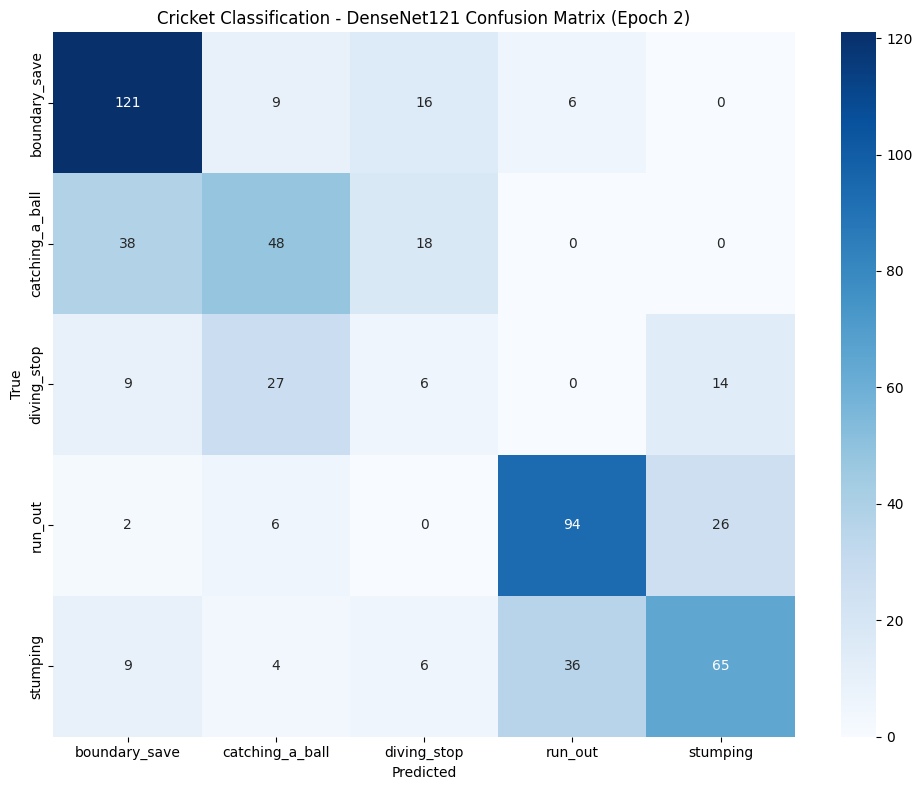

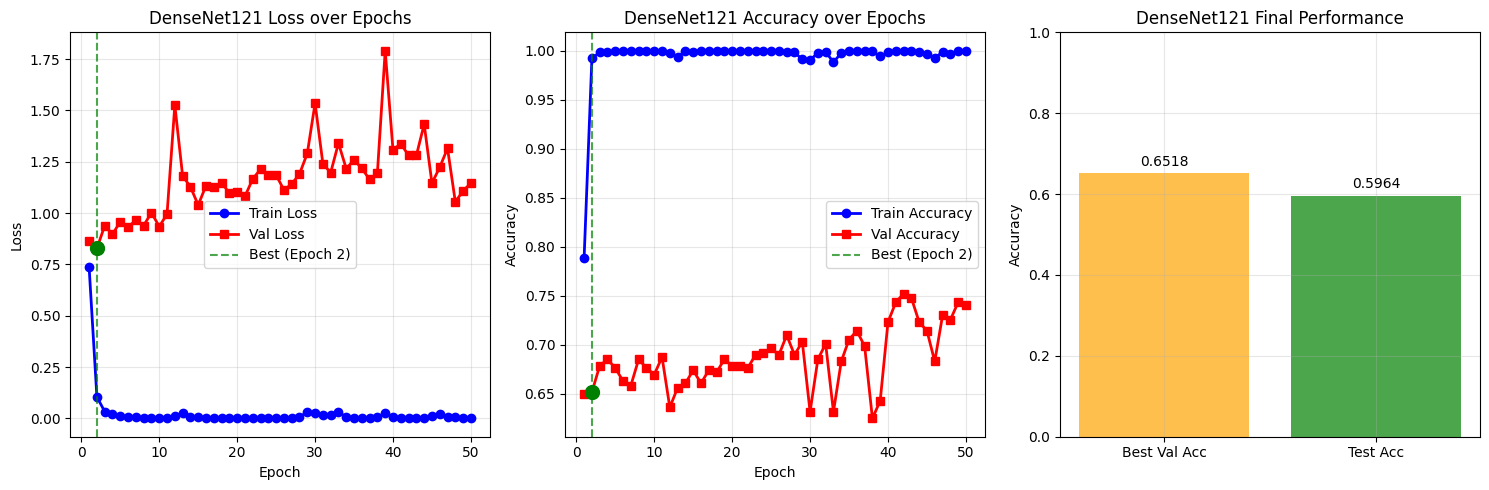


⏰ Final Timing Summary:
│ Total Training: 1670.87s (27.8 min)
│ Average per Epoch: 33.42s
│ Testing Time: 8.46s
│ Total Runtime: 1679.33s

🌐 DenseNet121 Advantages:
│ Dense Connections: Every layer connects to every other layer
│ Parameter Efficient: ~8M parameters (vs ~25M ResNet50)
│ Feature Reuse: Excellent gradient flow and feature reuse
│ Strong Performance: Often matches/exceeds ResNet with fewer parameters


In [10]:
import pandas as pd
import torch.optim as optim
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\n📋 Training Configuration:")
print(f"│ Model: DenseNet121 (pretrained)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 32")
print(f"│ Device: {device}")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\n🚀 Starting DenseNet121 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_densenet121_pretrained.pth')
    print(f"\n💾 Best model saved as 'best_cricket_densenet121.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_densenet121_history_pretrained.csv', index=False)
print("\n💾 Training history saved to 'cricket_densenet121_history_pretrained.csv'")

print(f"\n🎉 DenseNet121 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (DenseNet121):")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_densenet121.pth - Best model weights")
print(f"│ cricket_densenet121_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - DenseNet121 Confusion Matrix (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("DenseNet121 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("DenseNet121 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("DenseNet121 Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model Comparison Info
print(f"\n🌐 DenseNet121 Advantages:")
print(f"│ Dense Connections: Every layer connects to every other layer")
print(f"│ Parameter Efficient: ~8M parameters (vs ~25M ResNet50)")
print(f"│ Feature Reuse: Excellent gradient flow and feature reuse")
print(f"│ Strong Performance: Often matches/exceeds ResNet with fewer parameters")

In [11]:
import tempfile
import os
# Calculate model parameters

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)  # Clean up temporary file

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model file size: {model_size_mb:.2f} MB")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ DenseNet121 features: 1024")
print(f"│ Output classes: {len(classes)}")
print(f"│ Memory efficient: Dense connections")
print(f"│ Growth rate: 32 feature maps per layer")

📊 Total parameters: 6,958,981
📊 Trainable parameters: 6,958,981
📊 Model file size: 27.13 MB
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ DenseNet121 features: 1024
│ Output classes: 5
│ Memory efficient: Dense connections
│ Growth rate: 32 feature maps per layer
